
# Submission 2
This submission will use the resulting datasets of Notebook:  JD_DataPrepFeatureEngineering.ipynb which applied feature engineeing to bin hospital_id and icu_id into smaller categories, imputed missing data using Scikit-learn's KNNImputer (in versions from 0.22 on). then ran LightGBM

Adapting form notebook on WiDS Datathon with thanks! : https://www.kaggle.com/tejashshah/wids-eda-lgbm



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import lightgbm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

In [2]:
train = pd.read_csv('JD_train_fe_impute.csv')
print(train.shape)
display(train.nunique())
train.head()

(130157, 134)


age                                             535
bmi                                           45925
elective_surgery                                  2
height                                         1886
pre_icu_los_days                              10912
weight                                         5730
albumin_apache                                  345
apache_2_diagnosis                              662
apache_3j_diagnosis                            1176
apache_post_operative                             2
arf_apache                                        2
bilirubin_apache                               1929
bun_apache                                     1555
creatinine_apache                              3085
fio2_apache                                     732
gcs_eyes_apache                                  26
gcs_motor_apache                                 45
gcs_unable_apache                                 5
gcs_verbal_apache                                21
glucose_apac

,age,bmi,elective_surgery,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_min,d1_albumin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,h1_bun_max,h1_bun_min,h1_hco3_max,h1_hco3_min,d1_arterial_pco2_max,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,cirrhosis,hospital_size,icu_size,gender_M,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,hospital_admit_source_Chest Pain Center,hospital_admit_source_Direct Admit,hospital_admit_source_Emergency Department,hospital_admit_source_Floor,hospital_admit_source_ICU,hospital_admit_source_ICU to SDU,hospital_admit_source_Observation,hospital_admit_source_Operating Room,hospital_admit_source_Other,hospital_admit_source_Other Hospital,hospital_admit_source_Other ICU,hospital_admit_source_PACU,hospital_admit_source_Recovery Room,hospital_admit_source_Step-Down Unit (SDU),icu_stay_type_readmit,icu_stay_type_transfer,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,diabetes_mellitus
0,0.764045,0.148912,0.0,0.738140,0.004501,0.239484,0.323529,0.057971,0.228074,0.0,0.0,0.004992,0.219512,0.203125,0.293671,0.666667,1.0,0.0,0.75,0.230481,0.594595,0.318182,0.0,0.00000,0.331169,0.331169,0.082655,0.718489,0.571429,0.414634,0.947368,0.0,0.293987,0.062500,0.321429,0.184874,0.311688,0.512605,0.411429,0.233871,0.266667,0.239669,0.266667,0.256410,0.10,1.00,0.74,0.288732,0.268908,1.000000,0.898494,0.296078,0.425882,0.292453,0.450549,0.618644,0.666667,0.318966,0.500000,0.324561,0.500000,0.326531,0.095238,1.00,0.74,0.378378,0.439716,0.718750,0.352941,0.221311,0.245254,0.500000,0.395833,0.201486,0.200251,0.176580,0.298039,0.250000,0.25000,0.201923,0.315789,0.225080,0.333333,0.369176,0.397940,0.285714,0.294118,0.371429,0.472222,0.117557,0.117557,0.618182,0.618182,0.319222,0.127386,0.171991,0.272939,0.0,1.0,0.75,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,0.865169,0.237435,0.0,0.390478,0.006697,0.214383,0.382353,0.033816,0.092229,0.0,0.0,0.009651,0.040650,0.023897,1.000000,0.000000,0.4,0.0,0.00,0.189387,0.608108,0.588068,0.0,0.03750,0.246753,0.246753,0.042827,0.777587,0.517857,0.682927,0.394737,1.0,0.262806,0.287500,0.514286,0.411765,0.233766,0.504202,0.411429,0.483871,0.177778,0.495868,0.177778,0.230769,0.12,1.00,0.70,0.485915,0.218487,0.250000,0.543224,0.419608,0.534118,0.226415,0.285714,0.576271,0.592593,0.310345,0.235849,0.315789,0.235849,0.428571,0.148148,0.95,0.70,0.135135,0.127660,0.531250,0.147059,0.057377,0.054501,0.521739,0.520833,0.034355,0.026977,0.133

In [3]:
test = pd.read_csv('JD_test_fe_impute.csv')
print(test.shape)
display(test.nunique())
test.head()

(10234, 128)


age                                             79
bmi                                            995
elective_surgery                                 2
height                                         483
pre_icu_los_days                              2656
weight                                        1769
albumin_apache                                 299
apache_2_diagnosis                             183
apache_3j_diagnosis                            451
apache_post_operative                            2
arf_apache                                       2
bilirubin_apache                               604
bun_apache                                     465
creatinine_apache                             1194
fio2_apache                                    506
gcs_eyes_apache                                 23
gcs_motor_apache                                31
gcs_unable_apache                                4
gcs_verbal_apache                               21
glucose_apache                 

,age,bmi,elective_surgery,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_min,d1_albumin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,h1_bun_max,h1_bun_min,h1_hco3_max,h1_hco3_min,d1_arterial_pco2_max,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,cirrhosis,hospital_size,icu_size,gender_M,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,hospital_admit_source_Direct Admit,hospital_admit_source_Emergency Department,hospital_admit_source_Floor,hospital_admit_source_ICU to SDU,hospital_admit_source_Operating Room,hospital_admit_source_Other Hospital,hospital_admit_source_Other ICU,hospital_admit_source_Recovery Room,hospital_admit_source_Step-Down Unit (SDU),icu_stay_type_readmit,icu_stay_type_transfer,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU
0,0.692308,0.316111,0.0,0.262799,0.003380,0.272299,0.500000,0.043478,0.047211,0.0,0.0,0.033520,0.322217,0.122300,0.460759,1.0,1.0,0.0,1.00,0.108389,0.054697,0.703812,0.0,0.08750,0.328879,0.328879,0.098958,0.598345,0.482143,0.317073,0.580247,0.0,0.105336,0.192799,0.610526,0.495798,0.339196,0.076923,0.209945,0.494911,0.351648,0.522519,0.351648,0.298265,0.238095,1.000000,0.96,0.424597,0.281924,0.768390,0.640625,0.342476,0.532034,0.209944,0.422222,0.000000,0.058495,0.263751,0.455578,0.269565,0.462264,0.203335,0.197917,0.97,0.96,0.273138,0.438356,0.559148,0.500000,0.317460,0.330357,0.770833,0.808511,0.118135,0.129213,0.062485,0.249971,0.500000,0.50000,0.750,0.785714,0.740303,0.712869,0.271881,0.294042,0.709400,0.757576,0.257143,0.361111,0.249238,0.249238,0.62500,0.62500,0.303927,0.235176,0.308213,0.306947,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.871795,0.204927,0.0,0.653584,0.003149,0.215597,0.482353,0.077295,0.048120,0.0,0.0,0.042831,0.120831,0.063248,0.194937,1.0,1.0,0.0,1.00,0.062751,0.588999,0.595894,0.0,0.00625,0.214308,0.214308,0.095799,0.756249,0.875000,0.609756,0.567901,0.0,0.218089,0.211317,0.366488,0.470588,0.175879,0.504274,0.309392,0.540828,0.208791,0.571076,0.208791,0.515184,0.222222,1.000000,0.95,0.658858,0.190713,0.390656,0.765625,0.257937,0.297117,0.458059,0.488889,0.588235,0.617805,0.680648,0.586990,0.695652,0.594340,0.447336,0.250000,0.97,0.95,0.728368,0.458904,0.603233,0.458824,0.119048,0.142857,0.500000,0.638298,0.067358,0.078931,0.058454,0.157674,0.535714,0.62500,0.444,0.485714,0.509761,0.550063,0.291620,0.297844,0.253357,0.424242,0.600000,0.750000,0.145389,0.145389,0.61250,0.61250,0.472619,0.260402,0.314981,0.381000,0.0,0.0,

So we have a problem.  There are 6 more columns in the train set than the test.  This means that there were more values in the for one of the categories in the train set than in the test.  Let's find the difference...

In [7]:
list_train = train.columns
list_train

Index(['age', 'bmi', 'elective_surgery', 'height', 'pre_icu_los_days',
       'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis',
       'apache_post_operative',
       ...
       'icu_admit_source_Other Hospital', 'icu_admit_source_Other ICU',
       'icu_type_CSICU', 'icu_type_CTICU', 'icu_type_Cardiac ICU',
       'icu_type_MICU', 'icu_type_Med-Surg ICU', 'icu_type_Neuro ICU',
       'icu_type_SICU', 'diabetes_mellitus'],
      dtype='object', length=134)

In [9]:
list_test = test.columns
list_test

Index(['age', 'bmi', 'elective_surgery', 'height', 'pre_icu_los_days',
       'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis',
       'apache_post_operative',
       ...
       'icu_admit_source_Operating Room / Recovery',
       'icu_admit_source_Other Hospital', 'icu_admit_source_Other ICU',
       'icu_type_CSICU', 'icu_type_CTICU', 'icu_type_Cardiac ICU',
       'icu_type_MICU', 'icu_type_Med-Surg ICU', 'icu_type_Neuro ICU',
       'icu_type_SICU'],
      dtype='object', length=128)

In [16]:
list_train.difference(list_test) 

Index(['diabetes_mellitus', 'hospital_admit_source_Chest Pain Center',
       'hospital_admit_source_ICU', 'hospital_admit_source_Observation',
       'hospital_admit_source_Other', 'hospital_admit_source_PACU'],
      dtype='object')

Now we have the 6 different columns.  They come from hospital_admit_source.  We will drop the 5 from hospital_admit_source so that both dataset match with the exception of the label.  

In [17]:
train.drop(['hospital_admit_source_Chest Pain Center',
       'hospital_admit_source_ICU', 'hospital_admit_source_Observation',
       'hospital_admit_source_Other', 'hospital_admit_source_PACU'], axis=1,inplace=True)
print(train.shape)
train.head()

(130157, 129)


,age,bmi,elective_surgery,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_min,d1_albumin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,h1_bun_max,h1_bun_min,h1_hco3_max,h1_hco3_min,d1_arterial_pco2_max,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,cirrhosis,hospital_size,icu_size,gender_M,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,hospital_admit_source_Direct Admit,hospital_admit_source_Emergency Department,hospital_admit_source_Floor,hospital_admit_source_ICU to SDU,hospital_admit_source_Operating Room,hospital_admit_source_Other Hospital,hospital_admit_source_Other ICU,hospital_admit_source_Recovery Room,hospital_admit_source_Step-Down Unit (SDU),icu_stay_type_readmit,icu_stay_type_transfer,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,diabetes_mellitus
0,0.764045,0.148912,0.0,0.738140,0.004501,0.239484,0.323529,0.057971,0.228074,0.0,0.0,0.004992,0.219512,0.203125,0.293671,0.666667,1.0,0.0,0.75,0.230481,0.594595,0.318182,0.0,0.00000,0.331169,0.331169,0.082655,0.718489,0.571429,0.414634,0.947368,0.0,0.293987,0.062500,0.321429,0.184874,0.311688,0.512605,0.411429,0.233871,0.266667,0.239669,0.266667,0.256410,0.10,1.00,0.74,0.288732,0.268908,1.000000,0.898494,0.296078,0.425882,0.292453,0.450549,0.618644,0.666667,0.318966,0.500000,0.324561,0.500000,0.326531,0.095238,1.00,0.74,0.378378,0.439716,0.718750,0.352941,0.221311,0.245254,0.500000,0.395833,0.201486,0.200251,0.176580,0.298039,0.250000,0.25000,0.201923,0.315789,0.225080,0.333333,0.369176,0.397940,0.285714,0.294118,0.371429,0.472222,0.117557,0.117557,0.618182,0.618182,0.319222,0.127386,0.171991,0.272939,0.0,1.0,0.75,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,0.865169,0.237435,0.0,0.390478,0.006697,0.214383,0.382353,0.033816,0.092229,0.0,0.0,0.009651,0.040650,0.023897,1.000000,0.000000,0.4,0.0,0.00,0.189387,0.608108,0.588068,0.0,0.03750,0.246753,0.246753,0.042827,0.777587,0.517857,0.682927,0.394737,1.0,0.262806,0.287500,0.514286,0.411765,0.233766,0.504202,0.411429,0.483871,0.177778,0.495868,0.177778,0.230769,0.12,1.00,0.70,0.485915,0.218487,0.250000,0.543224,0.419608,0.534118,0.226415,0.285714,0.576271,0.592593,0.310345,0.235849,0.315789,0.235849,0.428571,0.148148,0.95,0.70,0.135135,0.127660,0.531250,0.147059,0.057377,0.054501,0.521739,0.520833,0.034355,0.026977,0.133829,0.372549,0.535714,0.59375,0.432692,0.508772,0.530547,0.589971,0.949821,0.869271,0.333333,0.411765,0.628571,0.777778,0.038168,0.038168,0.636364,0.636364,0.200864,0.000000,0

Now we are good to go.....


In [21]:
target = 'diabetes_mellitus'

In [18]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130157 entries, 0 to 130156
Data columns (total 129 columns):
 #    Column                                      Dtype  
---   ------                                      -----  
 0    age                                         float64
 1    bmi                                         float64
 2    elective_surgery                            float64
 3    height                                      float64
 4    pre_icu_los_days                            float64
 5    weight                                      float64
 6    albumin_apache                              float64
 7    apache_2_diagnosis                          float64
 8    apache_3j_diagnosis                         float64
 9    apache_post_operative                       float64
 10   arf_apache                                  float64
 11   bilirubin_apache                            float64
 12   bun_apache                                  float64
 13   creatinine_a

In [19]:
test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10234 entries, 0 to 10233
Data columns (total 128 columns):
 #    Column                                      Dtype  
---   ------                                      -----  
 0    age                                         float64
 1    bmi                                         float64
 2    elective_surgery                            float64
 3    height                                      float64
 4    pre_icu_los_days                            float64
 5    weight                                      float64
 6    albumin_apache                              float64
 7    apache_2_diagnosis                          float64
 8    apache_3j_diagnosis                         float64
 9    apache_post_operative                       float64
 10   arf_apache                                  float64
 11   bilirubin_apache                            float64
 12   bun_apache                                  float64
 13   creatinine_apa

In [22]:
y=train[target]
train=train.drop(target, axis=1)

In [23]:
# Parameters
params = {"objective": "binary", 
          "boosting": "gbdt",
          "metric": "auc",
          "n_jobs":-1,
          "verbose":-1}

num_folds = 10
roc_auc = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = train.columns
pred_on_test = np.zeros(test.shape[0])


kf = StratifiedKFold(n_splits=num_folds,shuffle=True, random_state=2020)
for index, (train_index, valid_index) in enumerate(kf.split(X=train,y=y)):
    print(f"FOLD {index+1}")

    X_train_fold, y_train_fold = train.iloc[train_index], y.iloc[train_index]
    X_valid_fold, y_valid_fold = train.iloc[valid_index], y.iloc[valid_index]

    dtrain = lightgbm.Dataset(X_train_fold, label=y_train_fold)
    dvalid = lightgbm.Dataset(X_valid_fold, label=y_valid_fold)

    lgb = lightgbm.train(params=params, train_set=dtrain, num_boost_round=2000, 
                         valid_sets=[dtrain, dvalid], verbose_eval=250, early_stopping_rounds=500)

    feature_importances[f'fold_{index + 1}'] = lgb.feature_importance()

    y_valid_pred = (lgb.predict(X_valid_fold,num_iteration=lgb.best_iteration))
    pred_on_test += (lgb.predict(test,num_iteration=lgb.best_iteration)) / num_folds

    # winsorization
    y_valid_pred = np.clip(a=y_valid_pred, a_min=0, a_max=1)
    pred_on_test = np.clip(a=pred_on_test, a_min=0, a_max=1)

    print(f"FOLD {index+1}: ROC_AUC  => {np.round(roc_auc_score(y_true=y_valid_fold, y_score=y_valid_pred),5)}")
    roc_auc.append(roc_auc_score(y_true=y_valid_fold, y_score=y_valid_pred)/num_folds)
    
print(f"Mean roc_auc for {num_folds} folds: {np.round(sum(roc_auc),5)}")

FOLD 1
Training until validation scores don't improve for 500 rounds
[250]	training's auc: 0.907444	valid_1's auc: 0.849363
[500]	training's auc: 0.944329	valid_1's auc: 0.84883
[750]	training's auc: 0.967488	valid_1's auc: 0.848093
Early stopping, best iteration is:
[299]	training's auc: 0.915965	valid_1's auc: 0.849884
FOLD 1: ROC_AUC  => 0.84988
FOLD 2
Training until validation scores don't improve for 500 rounds
[250]	training's auc: 0.907744	valid_1's auc: 0.844803
[500]	training's auc: 0.94332	valid_1's auc: 0.844057
Early stopping, best iteration is:
[231]	training's auc: 0.904164	valid_1's auc: 0.844907
FOLD 2: ROC_AUC  => 0.84491
FOLD 3
Training until validation scores don't improve for 500 rounds
[250]	training's auc: 0.906622	valid_1's auc: 0.855995
[500]	training's auc: 0.943667	valid_1's auc: 0.855301
Early stopping, best iteration is:
[231]	training's auc: 0.902979	valid_1's auc: 0.856422
FOLD 3: ROC_AUC  => 0.85642
FOLD 4
Training until validation scores don't improve fo

In [24]:
def plot_feature_importance(df, k_fold_object):
    df['average_feature_imp'] = df[['fold_{}'.format(fold + 1) for fold in range(k_fold_object.n_splits)]].mean(axis=1)
    plt.figure(figsize=(10, 40))
    sns.barplot(data=df.sort_values(by='average_feature_imp', ascending=False), x='average_feature_imp', y='feature');
    plt.title('Feature importance over {} folds average'.format(k_fold_object.n_splits))
    plt.show()

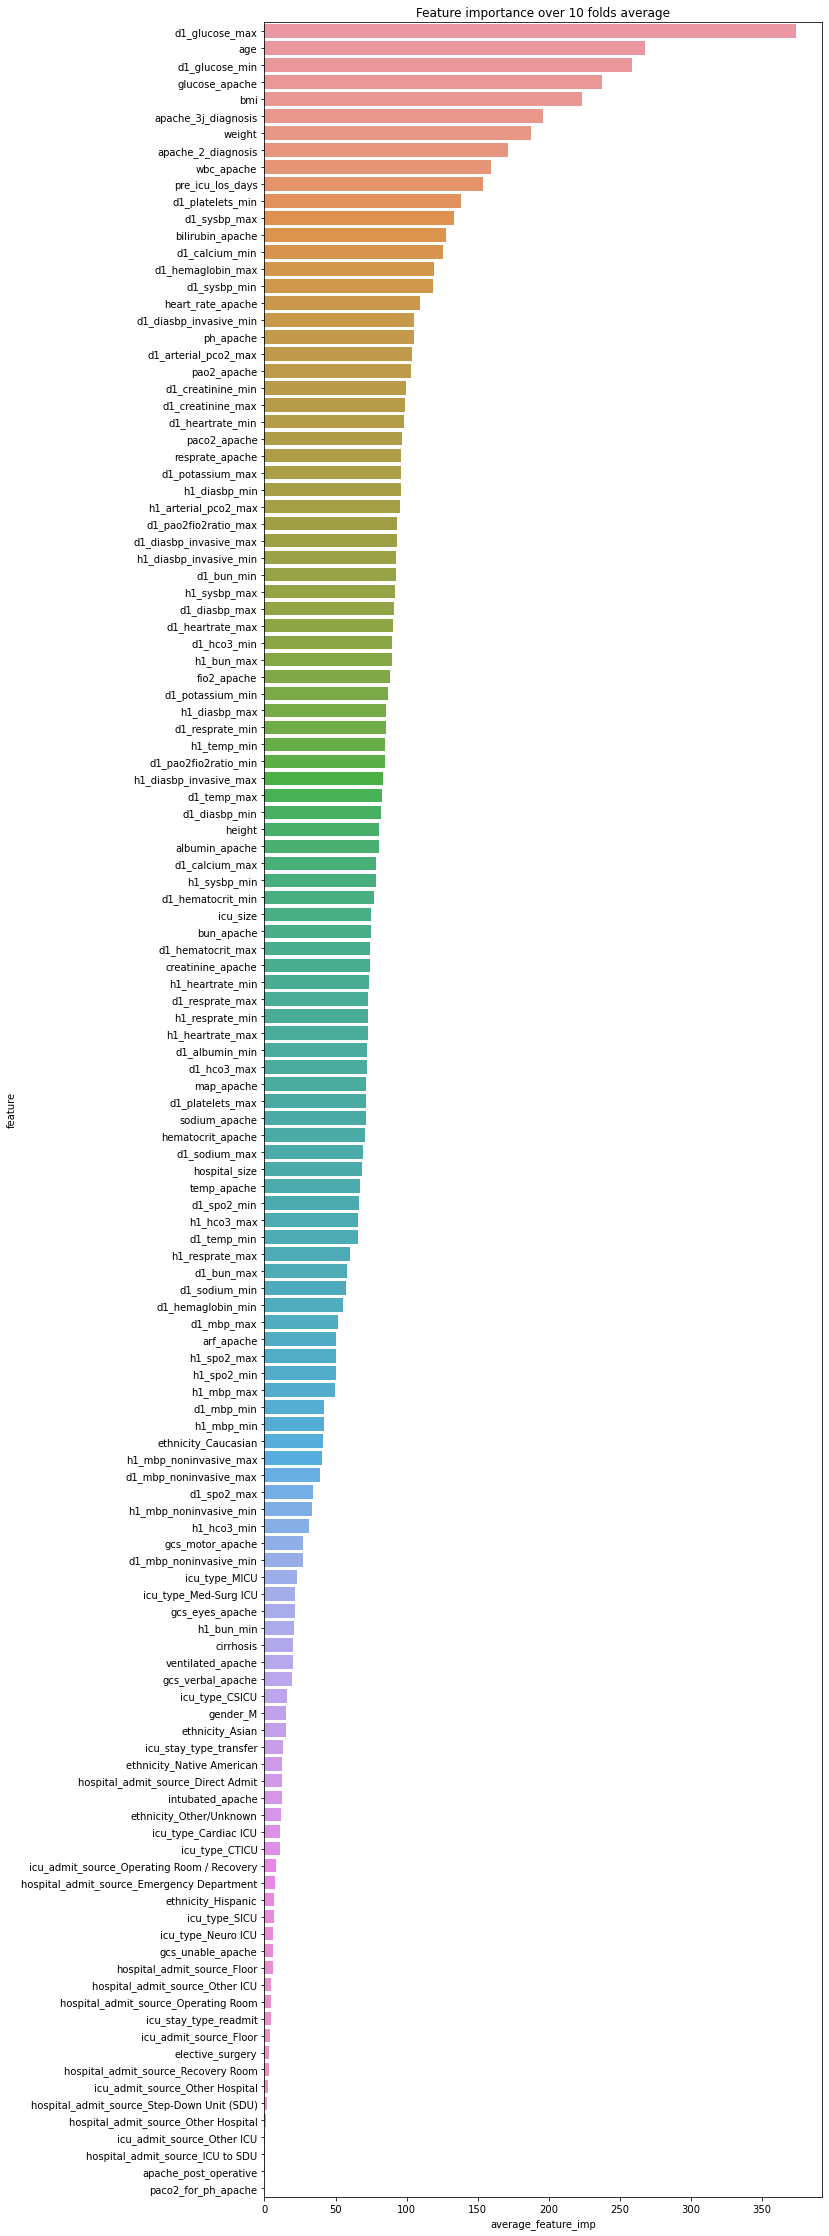

In [25]:
plot_feature_importance(df=feature_importances, k_fold_object=kf)

In [26]:
solution_template = pd.read_csv(r'SolutionTemplateWiDS2021.csv')

In [29]:
solution_template.diabetes_mellitus = pred_on_test
solution_template.to_csv("JD_2.csv", index=0)

Submission score:  0.49744 ----Yikes!  Let's redo with greatly reduced features based on feature importance.  Head to Sub3 version of this notebook...
